# Beamsize minimization with Xopt

## define the diagnostic

In [1]:
from measurement import get_DYG14, set_camera, set_background

save_image_location = "/home/awa/awa_data/01-18_6DReconstruction/beamsize_minimization"
image_diagnostic = get_DYG14()
image_diagnostic.save_image_location = save_image_location
image_diagnostic.target_charge = None


In [2]:
#set_background(image_diagnostic)

In [3]:
image_diagnostic

CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArrayData", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Jan 16 2024 15:21:35.430568475
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize0_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Jan 16 2024 15:21:35.430728551
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize1_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Jan 16 2024 15:21:35.432037095
................................................................

AWAEPICSImageDiagnostic(screen_name='13ARV1', ip_address='192.168.2.111', alias='DYG14', array_data_suffix='image1:ArrayData', array_n_cols_suffix='image1:ArraySize0_RBV', array_n_rows_suffix='image1:ArraySize1_RBV', resolution_suffix=None, resolution=1.0, beam_shutter_pv=None, extra_pvs=[], background_file=None, save_image_location='/home/awa/awa_data/01-16_6DReconstruction/beamsize_minimization', roi=ROI(xcenter=556, ycenter=806, xwidth=700, ywidth=700), min_log_intensity=4.0, bounding_box_half_width=3.0, wait_time=1.0, n_fitting_restarts=1, visualize=True, verbose=True, return_statistics=False, threshold=0.0, target_charge=None, target_charge_pv='AWAVXI11ICT:Ch4', charge_atol=1e-10, testing=False)

displaying image
fitting image


{'Cx': 373.66902937646336,
 'Cy': 379.18000698961487,
 'Sx': 22.776557623680407,
 'Sy': 10.478566133765561,
 'bb_penalty': -239.82729487181143,
 'total_intensity': 1483605136.0,
 'log10_total_intensity': 9.17131832811613,
 'AWAVXI11ICT:Ch4': 0.0}

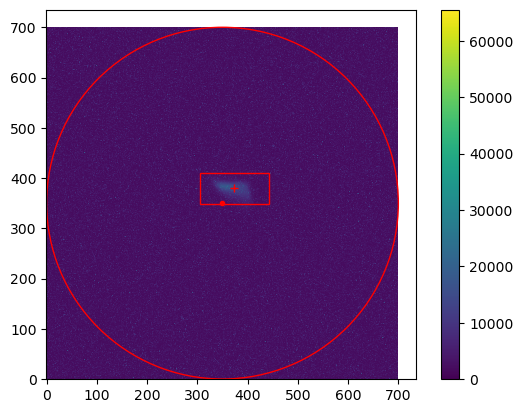

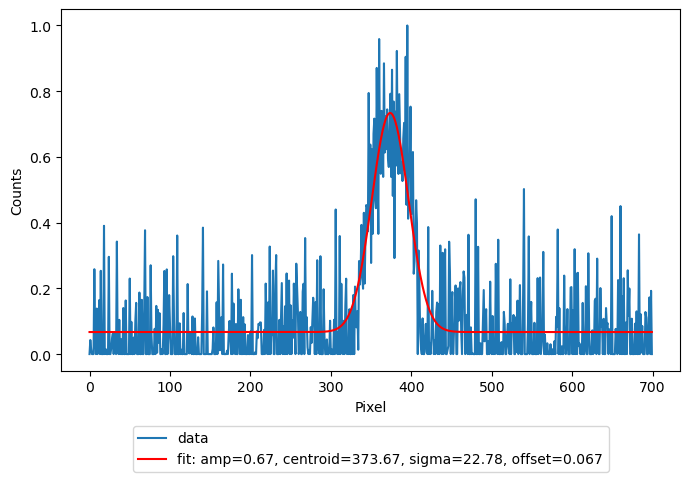

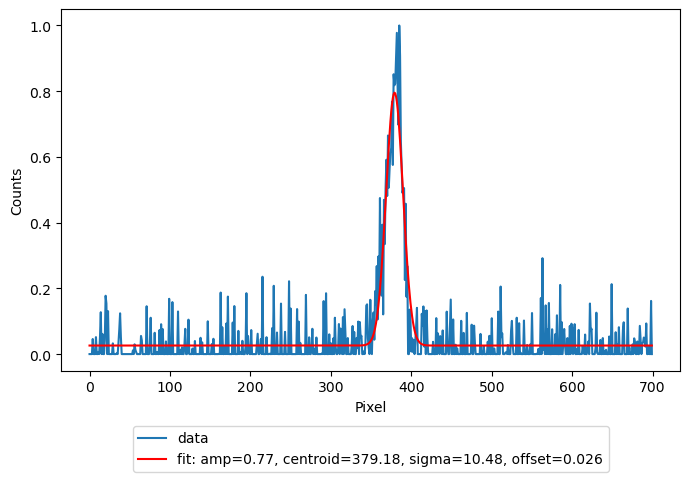

In [4]:
image_diagnostic.test_measurement()

### Define the evaluator

In [5]:
from epics import caput, caget
from xopt import Evaluator
import time
import numpy as np

IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", image_diagnostic.min_log_intensity]
        }
image_diagnostic.visualize = False
def evaluate_function(inputs: dict) -> dict:
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(1)

    results = image_diagnostic.measure_beamsize(1, **inputs)

    # add total beam size
    sigma_xy = np.sqrt(np.array(results["Sx"])**2 + np.array(results["Sy"])**2)
    roundness = np.abs(np.array(results["Sx"]) - np.array(results["Sy"]))
    results["total_size"] = sigma_xy + roundness
    print(results["total_size"], results["bb_penalty"])
    return results

evaluator = Evaluator(function=evaluate_function)

### Define VOCS
Here we define the names and ranges of input parameters, the names and settings of
objectives, and the names and settings of constraints. Note that the keys here should
 be referenced in the evaluate function above.

In [6]:
from xopt import VOCS

# define control PVs and ranges here
vocs = VOCS(
    variables = {
        #"AWA:Bira4Ctrl:Ch09": [0, 1], # Quad 4:9
        "AWA:Bira3Ctrl:Ch11": [-1.5, 1.5], # Quad 3:11
        "AWA:Bira4Ctrl:Ch10": [-2.0, 1.0], # Quad 4:10
        "AWA:Bira4Ctrl:Ch11": [-1.5, 1.75], # Quad 4:11
        
    },
    objectives = {"total_size":"MINIMIZE"},
    constraints = IMAGE_CONSTRAINTS
)

### Define the Generator

In [7]:
from xopt.generators import get_generator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = get_generator("expected_improvement")(
    vocs=vocs, gp_constructor=model_constructor, 
    n_interpolate_points=5, 
    turbo_controller="optimize",
)
generator.numerical_optimizer.max_time = 10.0

###  Combine into Xopt object

In [8]:
from xopt import Xopt
dump_filename = save_image_location + "/beamsize_minimization.yml"
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, dump_file=dump_filename)

## Introspection
Objects in Xopt can be printed to a string or dumped to a text file for easy
introspection of attributes and current configuration.

In [9]:
# Convenient representation of the state.
X


            Xopt
________________________________
Version: 2.1.0+27.g53bd9d64.dirty
Data size: 0
Config as YAML:
dump_file: /home/awa/awa_data/01-16_6DReconstruction/beamsize_minimization/beamsize_minimization.yml
evaluator:
  function: __main__.evaluate_function
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: false
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: 5
  n_monte_carlo_samples: 128
  name: expected_improvement
  numerical_optimizer:
    max_iter: 2000
    max_time: 10.0
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller:
    batch_size: 1
    best_value: null
    center_x: null
    dim: 3
    failure_counter: 0
    failure_tolerance: 2
    length: 0.25
    l

### Initialization

In [10]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd

X.evaluate_data(pd.DataFrame([{
    'AWA:Bira3Ctrl:Ch11': -0.655,
    'AWA:Bira4Ctrl:Ch10': -0.656,
    'AWA:Bira4Ctrl:Ch11': 0.317
}], columns=X.vocs.variable_names,index=[0]))

# get current point
current_value = dict(zip(X.vocs.variable_names, caget_many(X.vocs.variable_names)))

# get small region around current point to sample
random_sample_region = get_local_region(current_value,X.vocs, fraction=0.1)

random_sample_region

fitting image
34.23120466599163 -245.5502842689201


{'AWA:Bira3Ctrl:Ch11': [-0.9550000000000001, -0.355],
 'AWA:Bira4Ctrl:Ch10': [-0.9560000000000001, -0.356],
 'AWA:Bira4Ctrl:Ch11': [-0.008000000000000007, 0.642]}

In [11]:
X.data

,AWA:Bira3Ctrl:Ch11,AWA:Bira4Ctrl:Ch10,AWA:Bira4Ctrl:Ch11,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,AWAVXI11ICT:Ch4,save_filename,total_size,xopt_runtime,xopt_error
0,-0.655,-0.656,0.317,372.553022,378.351844,21.098442,10.38147,-245.550284,1.481777e+09,9.170783,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,34.231205,2.382682,False


In [12]:
# random sample in a local region
X.random_evaluate(10, custom_bounds=random_sample_region)

fitting image
57.536007246454375 -206.53500529533656
fitting image
nan 1066.2927754492532
fitting image
nan 391.46775187056085
fitting image
nan 1046.359199372556
fitting image
94.31193841536702 -35.5168164978291
fitting image
50.94770961916534 -188.08636003007948
fitting image
nan 261.1970306904527
fitting image
nan 186.53211792558943
fitting image
nan 411.23036512317424
fitting image
63.40416752173916 -171.58142389003598


,AWA:Bira3Ctrl:Ch11,AWA:Bira4Ctrl:Ch10,AWA:Bira4Ctrl:Ch11,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,AWAVXI11ICT:Ch4,save_filename,total_size,xopt_runtime,xopt_error
0,-0.667550,-0.476059,0.354205,319.873440,360.995816,34.397630,13.998657,-206.535005,1.478100e+09,9.169704,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,57.536007,2.419364,False
1,-0.391693,-0.758375,0.582422,NaN,NaN,NaN,NaN,1066.292775,1.490712e+09,9.173394,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.237482,False
2,-0.917537,-0.741438,0.461760,NaN,NaN,NaN,NaN,391.467752,1.471435e+09,9.167741,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.283690,False
3,-0.795977,-0.896211,0.584979,NaN,NaN,NaN,NaN,1046.359199,1.478015e+09,9.169679,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.217337,False
4,-0.808232,-0.400103,0.380732,269.582555,331.749238,63.042851,47.917058,-35.516816,1.482615e+09,9.171028,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,94.311938,2.195868,False
5,-0.396351,-0.367565,0.353417,328.364816,390.065841,20.705238,32.834923,-188.086360,1.476683e+09,9.169287,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,50.947710,2.225368,False
6,-0.690163,-0.830075,0.507672,NaN,NaN,NaN,NaN,261.197031,1.481987e+09,9.170844,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.247604,False
7,-0.905591,-0.631631,0.142110,NaN,NaN,NaN,NaN,186.532118,1.475261e+09,9.168869,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.258222,False
8,-0.916579,-0.804996,0.488214,NaN,NaN,NaN,NaN,411.230365,1.480738e+09,9.170478,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.256088,False
9,-0.783850,-0.736250,0.282869,380.963846,374.070597,24.143778,40.444814,-171.581424,1.484862e+09,9.171686,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,63.404168,2.213924,False


In [13]:
# examine the data stored in Xopt
X.data

,AWA:Bira3Ctrl:Ch11,AWA:Bira4Ctrl:Ch10,AWA:Bira4Ctrl:Ch11,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,AWAVXI11ICT:Ch4,save_filename,total_size,xopt_runtime,xopt_error
0,-0.655000,-0.656000,0.317000,372.553022,378.351844,21.098442,10.381470,-245.550284,1.481777e+09,9.170783,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,34.231205,2.382682,False
1,-0.667550,-0.476059,0.354205,319.873440,360.995816,34.397630,13.998657,-206.535005,1.478100e+09,9.169704,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,57.536007,2.419364,False
2,-0.391693,-0.758375,0.582422,NaN,NaN,NaN,NaN,1066.292775,1.490712e+09,9.173394,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.237482,False
3,-0.917537,-0.741438,0.461760,NaN,NaN,NaN,NaN,391.467752,1.471435e+09,9.167741,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.283690,False
4,-0.795977,-0.896211,0.584979,NaN,NaN,NaN,NaN,1046.359199,1.478015e+09,9.169679,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.217337,False
5,-0.808232,-0.400103,0.380732,269.582555,331.749238,63.042851,47.917058,-35.516816,1.482615e+09,9.171028,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,94.311938,2.195868,False
6,-0.396351,-0.367565,0.353417,328.364816,390.065841,20.705238,32.834923,-188.086360,1.476683e+09,9.169287,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,50.947710,2.225368,False
7,-0.690163,-0.830075,0.507672,NaN,NaN,NaN,NaN,261.197031,1.481987e+09,9.170844,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.247604,False
8,-0.905591,-0.631631,0.142110,NaN,NaN,NaN,NaN,186.532118,1.475261e+09,9.168869,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.258222,False
9,-0.916579,-0.804996,0.488214,NaN,NaN,NaN,NaN,411.230365,1.480738e+09,9.170478,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,NaN,2.256088,False


In [22]:
# run optimization
for i in range(10):
    print(i)
    X.step()

0
fitting image
20.827706550599554 -259.00530664762744
fitting image
48.24158344150997 -227.46076214525502
fitting image
27.66808648320331 -255.8991821797154
fitting image
24.663001751050288 -253.2750937189242
fitting image
31.764265507810244 -240.43827719134137
1
fitting image
30.22025741513163 -245.85582195361462
fitting image
27.3162788889469 -249.21916702508346
fitting image
28.420307153511764 -246.37394739127905
fitting image
27.297862953293603 -242.7454710557961
fitting image
23.840605501173805 -249.28115161188575
2
fitting image
28.45720314722042 -245.81182607654674
fitting image
25.377991543842437 -249.0321710756868
fitting image
23.84724119243962 -253.0662457860064
fitting image
24.4801825206791 -250.409722032346
fitting image
28.301534563594053 -245.80324900207415
3
fitting image
24.08863950039168 -252.2465981366845
fitting image
29.541478323982595 -250.75273279419318
fitting image
20.931846156704047 -253.36485389988408
fitting image
36.73036519383913 -244.80690089451167
fitt

<Axes: >

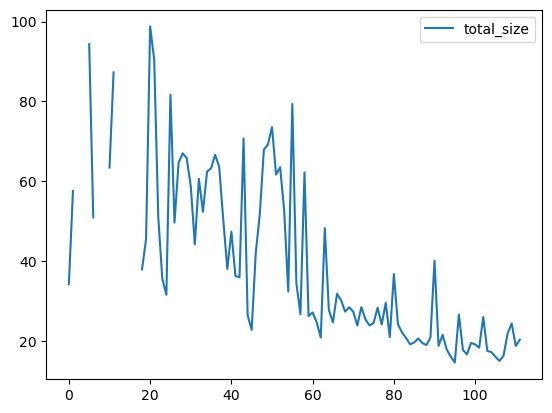

In [23]:
# visualize result
X.data.plot(y=X.vocs.objective_names[0])

<Axes: >

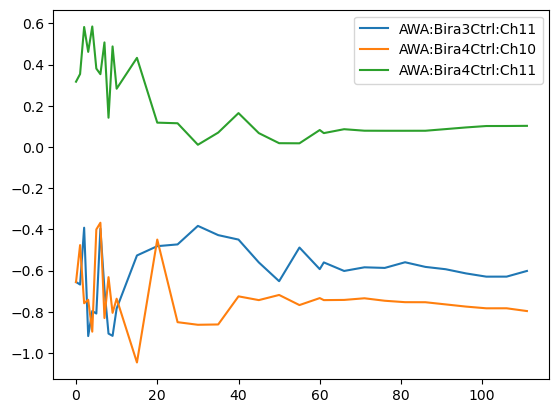

In [24]:
X.data.plot(y=X.vocs.variable_names)

displaying image
fitting image


{'Cx': 349.5004727393126,
 'Cy': 372.80569039307807,
 'Sx': 7.552419507225606,
 'Sy': 14.84291302530316,
 'bb_penalty': -278.7949291153758,
 'total_intensity': 1490015872.0,
 'log10_total_intensity': 9.173190894644021,
 'AWAVXI11ICT:Ch4': 0.0}

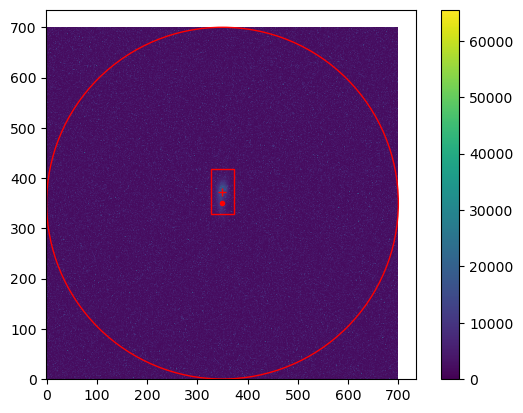

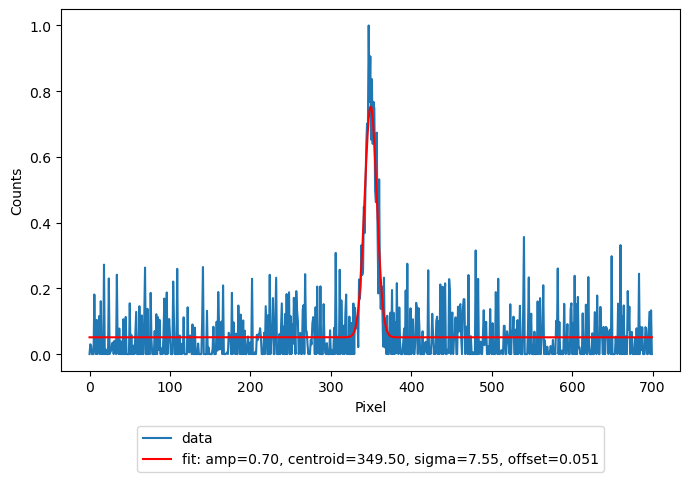

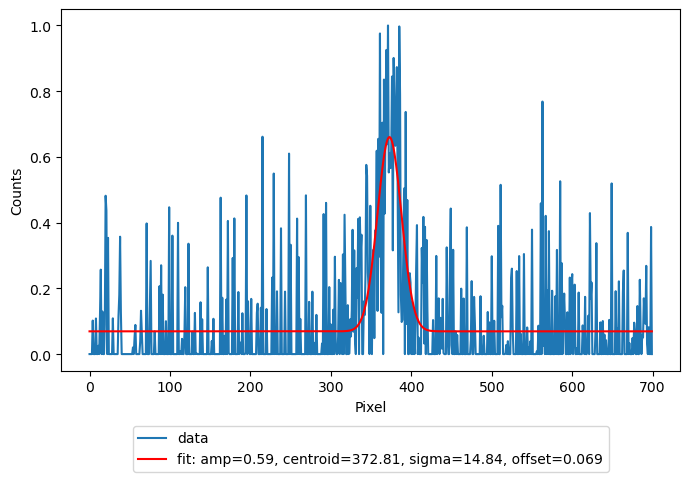

In [25]:
image_diagnostic.test_measurement()

In [26]:
idx, val = X.vocs.select_best(X.data)

In [27]:
X.evaluate_data(X.data.iloc[idx][X.vocs.variable_names])

fitting image
33.16013039634275 -264.11920548120463


,AWA:Bira3Ctrl:Ch11,AWA:Bira4Ctrl:Ch10,AWA:Bira4Ctrl:Ch11,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,AWAVXI11ICT:Ch4,save_filename,total_size,xopt_runtime,xopt_error
95,-0.609434,-0.772428,0.093389,339.434839,372.063009,6.725399,19.375755,-264.119205,1.483248e+09,9.171214,0.0,/home/awa/awa_data/01-16_6DReconstruction/beam...,33.16013,2.336285,False


CA.Client.Exception...............................................
    Context: "192.168.0.167:5064"
    Source File: ../tcpiiu.cpp line 926
    Current Time: Tue Jan 16 2024 17:58:05.358540116
..................................................................
CA.Client.Exception...............................................
    Context: "192.168.0.166:5064"
    Source File: ../tcpiiu.cpp line 926
    Current Time: Tue Jan 16 2024 17:58:11.714724687
..................................................................
Unexpected problem with CA circuit to server "192.168.0.167:5064" was "No route to host" - disconnecting
CA.Client.Exception...............................................
    Context: "192.168.0.167:5064"
    Source File: ../cac.cpp line 1237
    Current Time: Tue Jan 16 2024 18:13:31.516297367
..................................................................
Unexpected problem with CA circuit to server "192.168.0.166:5064" was "No route to host" - disconnecting
CA.Client

In [20]:
X.data.iloc[idx][X.vocs.variable_names].to_dict(orient="records")

[{'AWA:Bira3Ctrl:Ch11': -0.5601280713722122,
  'AWA:Bira4Ctrl:Ch10': -0.7430990659499442,
  'AWA:Bira4Ctrl:Ch11': 0.06740862209448481}]

displaying image
fitting image


{'Cx': 322.84593560786413,
 'Cy': 366.08922658679666,
 'Sx': 12.47555127093788,
 'Sy': 27.019937248587947,
 'bb_penalty': -233.34407510628358,
 'total_intensity': 1480809008.0,
 'log10_total_intensity': 9.170499047636254,
 'AWAVXI11ICT:Ch4': 0.0}

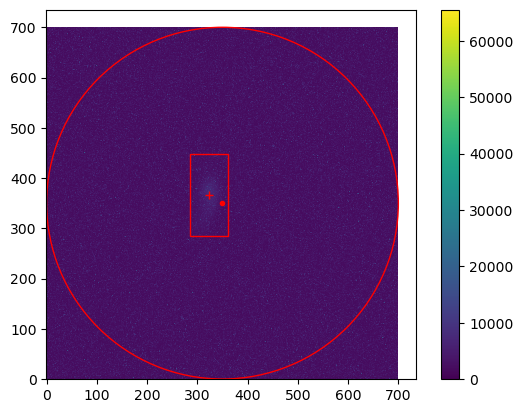

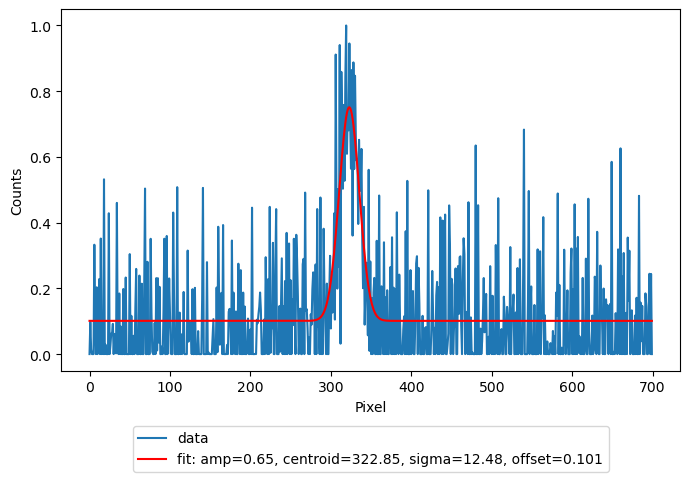

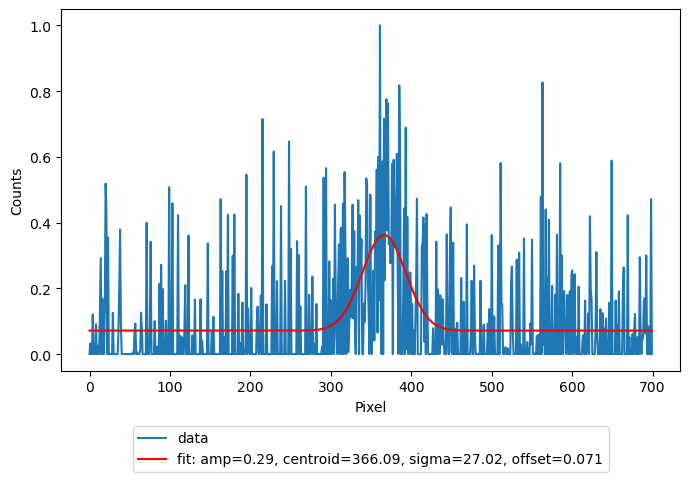

In [21]:
image_diagnostic.test_measurement()